In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from src.MinAggGNN import MinAggGNN
import matplotlib.pyplot as plt

device = torch.device('cuda')
L = 2
m = 2
eta = 0.0001
epochs = 20000

model = MinAggGNN(1, 8, L, 1, edge_dim = 1)
state_dict = torch.load('model_progress/model_final.pt')
# state_dict = torch.load('model_progress/model_checkpoints.pt')[1]
model.load_state_dict(state_dict)
model.eval()
model.to(device)

MinAggGNN(1, 1, num_layers=2)

In [2]:
from src.ComputationGraph import ComputationGraph, Circuit
from src.utils import MultiplicativeLoss
import torch_geometric as pyg
import networkx as nx

G = ComputationGraph(model)
G.add_inputs({'edge_attr' : [1, model.convs[0].agg_mlp.lins[0].weight[:,-1]],
              'input_self' : [3, model.convs[0].up_mlp.lins[0].weight[:,-1]]})
G.add_residual_connections({'edge_attr' : [5, model.convs[1].agg_mlp.lins[0].weight[:,-1].reshape(1,-1).cpu().detach()]})
G.add_residual_connections({4 : [7, model.convs[1].up_mlp.lins[0].weight[:,-8:].T.cpu().detach()]})

In [72]:
# criterion = MultiplicativeLoss()
criterion = torch.nn.MSELoss()
test_data = torch.load('data/test_data.pt', map_location=device)
corrupted_data = torch.load('data/test_data.pt', map_location=device)
for data_corr in corrupted_data:
    data_corr.x = torch.zeros_like(data_corr.x, device=device)
    data_corr.x[0] = 100.
    data_corr.edge_attr = torch.zeros_like(data_corr.edge_attr, device=device)

G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP')
G.calculate_scores(test_data, corrupted_data, criterion, which = 'EAP-IG', steps=5)

In [88]:
which = 'EAP-IG'
K = 8
C = Circuit(model, G, K=K, key=which)

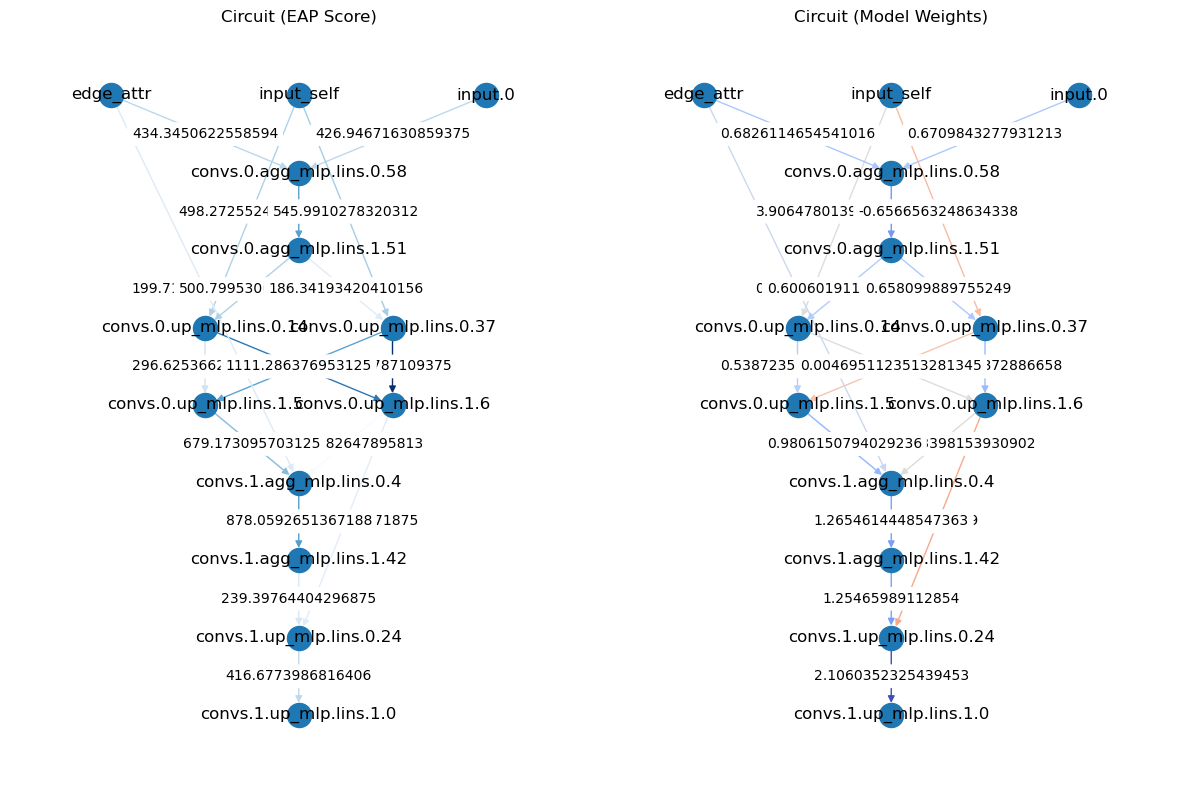

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
c_pos = nx.multipartite_layout(C, subset_key='layer', align='horizontal')
c_pos = {node: (x,-y) for (node, (x,y)) in c_pos.items()}

circuit_edges, circuit_edge_scores = zip(*nx.get_edge_attributes(C,which).items())
nx.draw(C, pos = c_pos, ax=ax[0],
        edgelist=circuit_edges,
        edge_color=circuit_edge_scores,
        edge_cmap=plt.cm.Blues,
        with_labels=True
        )
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[0],
                             edge_labels=nx.get_edge_attributes(C,which),
                             rotate=False)
ax[0].set_title('Circuit (EAP Score)')

_, circuit_edge_weights = zip(*nx.get_edge_attributes(C,'weight').items())
abs_vmax = max(circuit_edge_weights, key=abs)
nx.draw(C, pos = c_pos, ax=ax[1],
        edgelist = circuit_edges,
        edge_color = circuit_edge_weights,
        edge_cmap=plt.cm.coolwarm.reversed(),
        with_labels = True,
        edge_vmax = abs_vmax,
        edge_vmin = -abs_vmax
        )
nx.draw_networkx_edge_labels(C, pos = c_pos, ax=ax[1],
                             edge_labels=nx.get_edge_attributes(C,'weight'),
                             rotate=False)
ax[1].set_title('Circuit (Model Weights)')

ax[0].margins(x=.2)
ax[1].margins(x=.2)
plt.tight_layout()

In [90]:
data = test_data[1]
out = C.forward(data)
out

tensor([[-1.7445e-04],
        [ 6.5049e+00],
        [ 8.6608e+00],
        [ 6.8329e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [91]:
model(data.x, data.edge_index, edge_attr = data.edge_attr)

tensor([[-1.7384e-04],
        [ 6.6637e+00],
        [ 9.2810e+00],
        [ 6.9938e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [92]:
data.y

tensor([0.0000, 6.8541, 9.4119, 7.1960], device='cuda:0', requires_grad=True)